In [30]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, Aer, transpile,  execute
from qiskit.visualization import plot_bloch_multivector
from statistics import mode

### 2. Explain in words/pictures the effects of H, S, and T on the Bloch sphere. (That is, to what rotations do they correspond?)

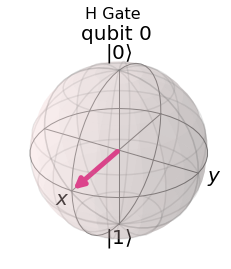

In [12]:
# Initialize a quantum circuit
qc = QuantumCircuit(1)

# H gate
qc.h(0)
state_h = Aer.get_backend('statevector_simulator').run(transpile(qc, Aer.get_backend('statevector_simulator'))).result().get_statevector()
plot_h = plot_bloch_multivector(state_h, title="H Gate")
plot_h 

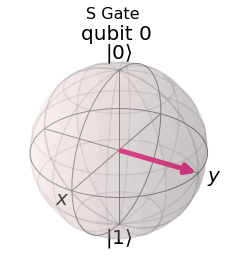

In [13]:
# S gate
qc.s(0)
state_s = Aer.get_backend('statevector_simulator').run(transpile(qc, Aer.get_backend('statevector_simulator'))).result().get_statevector()
plot_s = plot_bloch_multivector(state_s, title="S Gate")
plot_s 


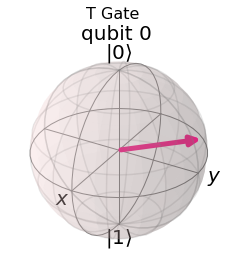

In [14]:
# T gate
qc.t(0)
state_t = Aer.get_backend('statevector_simulator').run(transpile(qc, Aer.get_backend('statevector_simulator'))).result().get_statevector()
plot_t = plot_bloch_multivector(state_t, title="T Gate")
plot_t 

### (3). Show how to encode two classical bits into one qubit such that any one bit can be recovered correctly with probability greater than $85\%$

In [15]:
def encode(bits):
    qc = QuantumCircuit(1)
    if bits[0] == '1':
        qc.x(0)
    if bits[1] == '1':
        qc.z(0)
    return qc

def decode_for_b1(qc):
    backend = Aer.get_backend('qasm_simulator')
    qc.measure_all()
    result = execute(qc, backend, shots=1).result()
    counts = result.get_counts()
    return list(counts.keys())[0][0]  # Since it's one qubit, and we take one shot

def decode_for_b2(qc):
    backend = Aer.get_backend('qasm_simulator')
    qc.h(0)
    qc.measure_all()
    result = execute(qc, backend, shots=1).result()
    counts = result.get_counts()
    return list(counts.keys())[0][0]  # we take one shot just like with the other one

def main():
    bits = ('1', '0') 
    trials = 1000  # large # of trials to get a high avg recovery probability

    b1_results = []
    b2_results = []
    for _ in range(trials):
        qc = encode(bits)
        
        # Decode b1
        b1 = decode_for_b1(qc.copy())  # since measurement modifies the circuit, we are using a copy
        b1_results.append(b1)
        
        # Decode b2
        b2 = decode_for_b2(qc.copy())  
        b2_results.append(b2)

    b1_most_common = mode(b1_results)
    b2_most_common = mode(b2_results)
    b1_accuracy = b1_results.count(b1_most_common) / trials
    b2_accuracy = b2_results.count(b2_most_common) / trials

    print(f"Original bits: {bits}")
    print(f"Decoded b1 with accuracy: {b1_accuracy*100}%")
    print(f"Decoded b2 with accuracy: {b2_accuracy*100}%")

if __name__ == "__main__":
    main()


Original bits: ('1', '0')
Decoded b1 with accuracy: 100.0%
Decoded b2 with accuracy: 51.6%


### 5(b). Write and test these functions: 
### 1. input: a pure state, as a vector
### output: the corresponding density matrix (watch out for complex numbers!) 
### 2. input: a $2^n \times 2^n$ matrix M, a list of indices from 1 to n
### output: M, with the specified qubits traced out

In [17]:
# 1. input a pure state, a vector, output the DM

def to_density_matrix(state):
    """
    Converts a state vector to a density matrix.
    
    :param state: A state vector as a 1D numpy array.
    :return: A density matrix.
    """
    return np.outer(state, np.conj(state))


state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])  # state |0> + |1>
density_matrix = to_density_matrix(state)
print("Density matrix of the state:")
print(density_matrix)

Density matrix of the state:
[[0.5 0.5]
 [0.5 0.5]]


In [18]:
# 2. input a 2x2 matrix M a list of incides from 1 to n and out M with the specified qubit traced out

def partial_trace(matrix, indices, dim=2):
    """
    Perform a partial trace over the specified indices.
    
    :param matrix: Input matrix to perform the partial trace on.
    :param indices: A list of indices to trace over.
    :param dim: The dimension of each subsystem in the tensor product.
    :return: The resulting matrix after the partial trace.
    """
    n = int(np.log2(matrix.shape[0]) / np.log2(dim))
    new_dim = dim ** (n - len(indices))
    result = np.zeros((new_dim, new_dim), dtype=complex)
    
    for i in range(new_dim):
        for j in range(new_dim):
            for k in indices:
                i_index = [i // (dim ** (n - k)) % dim for k in range(n)]
                j_index = [j // (dim ** (n - k)) % dim for k in range(n)]
                sum_val = 0
                for l in range(dim):
                    i_index[k - 1] = l
                    j_index[k - 1] = l
                    old_i = sum(i_index[k] * (dim ** (n - k)) for k in range(n))
                    old_j = sum(j_index[k] * (dim ** (n - k)) for k in range(n))
                    sum_val += matrix[old_i, old_j]
                result[i, j] += sum_val
                
    return result


matrix = np.array([[1, 0, 0, 0], [0, 2, 0, 0], [0, 0, 3, 0], [0, 0, 0, 4]], dtype=complex)  
result_matrix = partial_trace(matrix, [2])  
print("\nMatrix after tracing out the second qubit:")
print(result_matrix)



Matrix after tracing out the second qubit:
[[4.+0.j 4.+0.j]
 [4.+0.j 4.+0.j]]


In [28]:
# Use these functions to double check the answers to (a)

def to_density_matrix(state_vector):
    return np.outer(state_vector, np.conj(state_vector))

def partial_trace(rho, keep, dim=2):
    n = rho.shape[0]
    num_qubits = int(np.log2(n))
    
    axes = list(range(num_qubits))
    to_trace_out = set(range(num_qubits)) - set(keep)
    
    for qubit in sorted(to_trace_out, reverse=True):
        rho = np.trace(rho.reshape([dim] * 2 * num_qubits), axis1=qubit, axis2=qubit + num_qubits)
        num_qubits -= 1

    return rho

# Constructing the state |ψ⟩
psi = (1/np.sqrt(2)) * (np.kron(np.kron([1, 0], [1, 0]), [1, 0]) +
                        np.kron(np.kron([1, 0], [1, 0]), [0, 1]) +
                        np.kron(np.kron([0, 1], [0, 1]), [0, 1]))

# Computing ρ_ABC
rho_ABC = to_density_matrix(psi)

# Computing the reduced density matrices
rho_A = partial_trace(rho_ABC, [0])  
rho_B = partial_trace(rho_ABC, [1])  
rho_C = partial_trace(rho_ABC, [2])  
rho_AB = partial_trace(rho_ABC, [0, 1])  

print("ρ_A:")
print(rho_A)
print("\nρ_B:")
print(rho_B)
print("\nρ_C:")
print(rho_C)
print("\nρ_AB:")
print(rho_AB)



ρ_A:
[[1.  0. ]
 [0.  0.5]]

ρ_B:
[[1.  0. ]
 [0.  0.5]]

ρ_C:
[[0.5 0.5]
 [0.5 1. ]]

ρ_AB:
[[[[1.  0. ]
   [0.  0.5]]

  [[0.  0. ]
   [0.  0. ]]]


 [[[0.  0. ]
   [0.  0. ]]

  [[0.5 0. ]
   [0.  0.5]]]]


### 6(a). Consider a random walk on the $n-$vertex cycle. At each step, you flip a coin to decide whether to go left or right; the stochastic tranistion matrix is A 
### Using your favorite numberical program, plot the distrubition after 50 steps with $n=100$, starting from 0. 

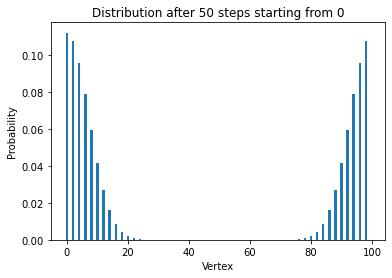

In [31]:
n = 100
steps = 50

# Defining the transition matrix A
A = np.zeros((n, n))
for j in range(n):
    A[j][(j-1) % n] = 0.5
    A[j][(j+1) % n] = 0.5

# Initial state
state = np.zeros(n)
state[0] = 1

# Evolving the state using the transition matrix
for _ in range(steps):
    state = np.dot(A, state)

# Plotting
plt.bar(range(n), state)
plt.title("Distribution after 50 steps starting from 0")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()


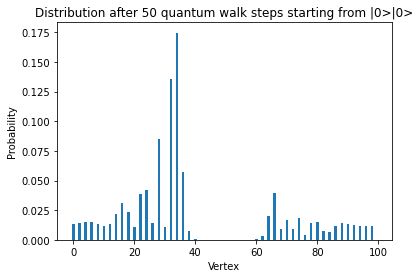

In [32]:
n = 100
steps = 50

# Define the Hadamard gate for the coin
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

# Define the shift operator for the walk
S = np.zeros((n * 2, n * 2))
for j in range(n):
    # Move left if coin is |0>
    S[2*j][(2*((j-1)%n))] = 1
    # Move right if coin is |1>
    S[2*j + 1][2*((j+1)%n) + 1] = 1

# Define the coin operator
C = np.kron(np.eye(n), H)

# Starting state: |0>|0>
state = np.zeros(n * 2)
state[0] = 1

# Applying the quantum walk operators
for _ in range(steps):
    state = np.dot(S, np.dot(C, state))

# Projecting the state on the position basis to get the probabilities
probabilities = [np.abs(state[i])**2 + np.abs(state[i+1])**2 for i in range(0, 2*n, 2)]

# Plotting
plt.bar(range(n), probabilities)
plt.title("Distribution after 50 quantum walk steps starting from |0>|0>")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()
